In [ ]:
from bs4 import BeautifulSoup
import re
import os
import pandas as pd 
import numpy as np 
import csv
import base64
import glob
from scipy.stats import zscore
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# Loading data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# OASIS subjects
!gdown 1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV -O data.rar

Downloading...
From (uriginal): https://drive.google.com/uc?id=1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV
From (redirected): https://drive.google.com/uc?id=1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV&confirm=t&uuid=d0e030f0-a42d-499b-a100-2cb11300422a
To: /content/data.rar
100% 314M/314M [00:06<00:00, 49.9MB/s]


In [ ]:
!mkdir subjects

In [ ]:
!unrar x "/content/data.rar" "/content/subjects/"
!rm -r "data.rar"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/data.rar

Extracting  /content/subjects/ana_press_6_esfand.csv                       0%  OK 
Extracting  /content/subjects/ana_press_all.csv                            1%  OK 
Extracting  /content/subjects/asriran_6_esfand.csv                         1%  OK 
Extracting  /content/subjects/asriran_all.csv                              3%  4%  5%  6%  OK 
Extracting  /content/subjects/entekhab_6_esfand.csv                        6%  OK 
Extracting  /content/subjects/entekhab_all.csv                             7%  9% 10% 11% 13% 14% 15%  OK 
Extracting  /content/subjects/farsnews_6_esfand.csv                       15%  OK 
Extracting  /content/subjects/farsnews_all.csv                            16% 18% 19% 21% 22% 23% 25% 26% 27% 29%  OK 
Extractin

# Defining a function for convrting one html to df
## in other words, Extracting features:

In [ ]:
def title_content_intersection_ratio(title, content):
    title = np.array(title.split())
    content = np.array(content.split())
    intersection = np.intersect1d(title , content)
    try:
        return len(intersection)/len(content)
    except:
        return 0

In [ ]:
def html_to_df(html_doc):

    content_list = []
    title_content_intersection_ratio_list = []
    content_depth_list = []
    content_words_number_list = []
    labels = []

    soup = BeautifulSoup(html_doc, "html.parser")

    description = soup.find('meta', {'property': 'og:description'})["content"]
    # print('description:', description)

    title = soup.find('meta', {'property': 'og:title'})["content"]
    # print('title:', title)


    def traverse(t, current_path=None):
        if current_path is None:
            current_path = [t.name]
            # print('current_path', current_path)


        for tag in t.find_all(recursive=False):

            if not tag.find():        
                    path = current_path + [tag.name, tag.find(string=True)]
                    content = tag.find(string=True)


                    if str(content) != 'None':
                          content = tag.find(string=True).strip()
                        #   print('path:', path)
                        #   print('depth:', len(path))
                        #   print( 'leaf tag:', tag.name)
                          # print('content:', str(content))
                        #   print('number of words:', len(str(content).split()))
                          
                          
                          if str(content) == description:
                            labels.append(1)
                            # print('description ***********************')
                          elif str(content) == title:
                            labels.append(2)
                            # print('Title ****************************')
                          else:
                            labels.append(0)
                            # print("NOTHING")



                          # print("\n")
                          content_list.append(str(content))
                          content_depth_list.append(float(len(path)))
                          content_words_number_list.append(len(str(content).split()))
                          title_content_intersection_ratio_list.append(title_content_intersection_ratio(title, str(content)))

                  
            else:
                traverse(tag, current_path + [tag.name])
            

    
    traverse(soup.body)
    # traverse(soup.article)
    # traverse(soup.find("article", {'class': 'news-content'})) # varzesh3
    # print(content_list)
    # print(content_depth_list)
    # print(content_words_number_list)
    # print(labels)


    # z score normalize number of words
    content_words_number_list = zscore(content_words_number_list)
    # print("content_words_number_list : ", content_words_number_list)


    # lists to dictionary
    data_dict = {'content': content_list,
                 'depth': content_depth_list,
                 'title_content_intersection_ratio' : title_content_intersection_ratio_list ,
                 'words in content': content_words_number_list, 
                 'label': labels}  


    # dict to df
    df_output = pd.DataFrame(data_dict)


    # # if more than 1 description we have:
    # if df_output['label'].value_counts()[1] >= 2 :
    #   df_output.loc[df_output['label']==1]


    # drop rows when len(content) <= 3
    for i in range(len(df_output['content'])):
      if len((df_output['content'][i]).split()) <= 3:
        df_output.drop(i, inplace=True)
    df_output.reset_index(drop=True, inplace=True)


    return df_output

In [ ]:
# # html to df on one sample html testing
# html_doc = """
# <head>
#    <meta property="og:title" content="this is title.">
#    <meta property="og:description" content="this is description.">
# </head>
# <body>
#    <h2>this is title.</h2>
#    <span>
#       <p>Google Chrome is a web browser</p>
#       <p>Chrome is a web browser developed by google </p>
#       <div>
#          <div>
#             <p>This is a leaf node</p>
#          </div>
#       </div>
#    </span>
# </body>
# """ 
# df_sample = html_to_df(html_doc)
# df_sample

,content,depth,title_content_intersection_ratio,words in content,label
0,Google Chrome is a web browser,4.0,0.166667,0.27735,0
1,Chrome is a web browser developed by google,4.0,0.125000,1.38675,0
2,This is a leaf node,6.0,0.200000,-0.27735,0


# Defining a function to do one_html_to_df on each news site (groups of htmls)

In [ ]:
def one_site_crawl(df_all):
  output = pd.DataFrame(columns=['content','depth', 'title_content_intersection_ratio','words in content', 'label']) 

  # for i in range(2):
  for i in tqdm(range(len(df_all['html']))):
      html_string = base64.b64decode(df_all['html'][i]) # type:byte
      try:
        html_doc = html_string.decode("utf8") # type:string
        if ('og:description' in html_doc) and ('og:title' in html_doc):
          output = output.append(html_to_df(html_doc))
          
      except:
        html_doc = html_string.decode("latin-1") # type:string  
        if ('og:description' in html_doc)  and ('og:title' in html_doc):
          output = output.append(html_to_df(html_doc))


  # reset index
  output.reset_index(drop=True, inplace=True)
  output


  # z score normalize '''each web page''' depth column
  # Calculate the zscores and drop zscores into new column
  output['depth'] = zscore(output['depth'])


  # filter output
  filter_output = output[output["title_content_intersection_ratio"] > 0]

  return filter_output

# Appling on each news site

In [ ]:
ana_press_all =  one_site_crawl(pd.read_csv('/content/subjects/ana_press_all.csv', encoding='utf8', on_bad_lines='skip'))
asriran_all =  one_site_crawl(pd.read_csv('/content/subjects/asriran_all.csv', encoding='utf8', on_bad_lines='skip'))
entekhab_all =  one_site_crawl(pd.read_csv('/content/subjects/entekhab_all.csv', encoding='utf8', on_bad_lines='skip'))
farsnews_all =  one_site_crawl(pd.read_csv('/content/subjects/farsnews_all.csv', encoding='utf8', on_bad_lines='skip'))
iscanews_all =  one_site_crawl(pd.read_csv('/content/subjects/iscanews_all.csv', encoding='utf8', on_bad_lines='skip'))
isna_all =  one_site_crawl(pd.read_csv('/content/subjects/isna_all.csv', encoding='utf8', on_bad_lines='skip'))
jahannews_all =  one_site_crawl(pd.read_csv('/content/subjects/jahannews_all.csv', encoding='utf8', on_bad_lines='skip'))
khabaronline_all =  one_site_crawl(pd.read_csv('/content/subjects/khabaronline_all.csv', encoding='utf8', on_bad_lines='skip'))
mashreghnews_all =  one_site_crawl(pd.read_csv('/content/subjects/mashreghnews_all.csv', encoding='utf8', on_bad_lines='skip'))
mehrnews_all =  one_site_crawl(pd.read_csv('/content/subjects/mehrnews_all.csv', encoding='utf8', on_bad_lines='skip'))
shana_all =  one_site_crawl(pd.read_csv('/content/subjects/shana_all.csv', encoding='utf8', on_bad_lines='skip'))
tasnimnews_all =  one_site_crawl(pd.read_csv('/content/subjects/tasnimnews_all.csv', encoding='utf8', on_bad_lines='skip'))
varzesh3_all =  one_site_crawl(pd.read_csv('/content/subjects/varzesh3_all.csv', encoding='utf8', on_bad_lines='skip'))
yjcnews_all =  one_site_crawl(pd.read_csv('/content/subjects/yjcnews_all.csv', encoding='utf8', on_bad_lines='skip'))

  0%|          | 0/1959 [00:00<?, ?it/s]

  0%|          | 0/4169 [00:00<?, ?it/s]

  0%|          | 0/5669 [00:00<?, ?it/s]

  0%|          | 0/10731 [00:00<?, ?it/s]

  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/10807 [00:00<?, ?it/s]

  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/12844 [00:00<?, ?it/s]

  0%|          | 0/7939 [00:00<?, ?it/s]

  0%|          | 0/7599 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/13700 [00:00<?, ?it/s]

  0%|          | 0/2327 [00:00<?, ?it/s]

  0%|          | 0/3711 [00:00<?, ?it/s]

In [ ]:
# concatenating dfs
df_list = [ana_press_all,
           asriran_all, 
           entekhab_all, 
           farsnews_all, 
           iscanews_all, 
           isna_all, 
           jahannews_all, 
           khabaronline_all, 
           mashreghnews_all, 
           mehrnews_all, 
           shana_all, 
           tasnimnews_all, 
           varzesh3_all, 
           yjcnews_all]
output = pd.concat(df_list, axis=0, ignore_index=True)

In [ ]:
# main df of all dataset
output

,content,depth,title_content_intersection_ratio,words in content,label
0,هرکه زورش بیش حقش بیشتر!,-0.670283,1.000000,-0.031898,2
1,- اگرچه پیشرفت فیزیکی 97 درصدی داشته است- و هم...,-1.182933,0.002222,18.174941,0
2,ضریح حرم امام علی (ع) با بیش از ۱۰۰۰ شاخه گل ط...,0.867670,0.062500,0.418159,0
3,هرکه زورش بیش حقش بیشتر!,-0.670283,1.000000,-0.031898,2
4,- اگرچه پیشرفت فیزیکی 97 درصدی داشته است- و هم...,-1.182933,0.002222,18.174941,0
...,...,...,...,...,...
2897395,۱۰ اثر مفرغی لرستان ثبت ملی شد,0.278098,0.142857,0.953992,0
2897396,پیش‌بینی بیش از یک هزار و ۵۰۰ کلاس درس برای اس...,0.278098,0.200000,2.932176,0
2897397,تاکنون موردی از شیوع تب برفکی در لرستان گزارش ...,0.278098,0.181818,1.943084,0
2897398,مردم لرستان در سالروز ولادت سرداران کربلا غرق ...,0.278098,0.200000,1.695811,0


# Saving df for future uses

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# output.to_csv('/content/drive/MyDrive/output.csv', encoding='utf-8')

In [ ]:
# df_out_csv = pd.read_csv('/content/drive/MyDrive/output.csv')

# Training models

## Extra Trees Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
def confusion_matrix_(test_labels, predicted_labels, version):
    if not os.path.exists('result'):
        os.makedirs('result')

    print("\nconfusion_matrix\n")
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.subplots(figsize=(10, 6))
    sn.heatmap(cm, annot = True, fmt = 'd', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    # plt.savefig(f'result/confusion_matrix_{version}.png', bbox_inches='tight')

def model_result(y_test,y_pred, version):
    ra_score = roc_auc_score(y_test,y_pred)
    a_score = accuracy_score(y_test,y_pred)
    p_score = precision_score(y_test,y_pred)
    r_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('roc_auc_score : ',ra_score)
    print('accuracy_score: ',a_score)
    print('precision_score: ',p_score)
    print('recall_score: ',r_score)
    print('f1-score :', f1)
    print('confusion_matrix: ',confusion_matrix(y_test,y_pred))
    confusion_matrix_(y_test,y_pred, version)

In [ ]:
filter_output = output[output["title_content_intersection_ratio"] > 0]
filter_output[filter_output["label"] == 2]["label"] = 1
filter_output['label'] = filter_output['label'].astype(bool)
X = filter_output.drop(['label', 'content'],axis=1)
# boolean
y = filter_output['label']

In [ ]:
filter_output['label'] = filter_output['label'].astype(int)
y_int = filter_output['label']

In [ ]:
X

,depth,title_content_intersection_ratio,words in content
0,-0.670283,1.000000,-0.031898
1,-1.182933,0.002222,18.174941
2,0.867670,0.062500,0.418159
3,-0.670283,1.000000,-0.031898
4,-1.182933,0.002222,18.174941
...,...,...,...
2897395,0.278098,0.142857,0.953992
2897396,0.278098,0.200000,2.932176
2897397,0.278098,0.181818,1.943084
2897398,0.278098,0.200000,1.695811


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

In [ ]:
y.value_counts()

False    2771970
True      125430
Name: label, dtype: int64

roc_auc_score :  0.9452508919850118
accuracy_score:  0.9932615448332989
precision_score:  0.9489001692047377
recall_score:  0.8926809079621788
f1-score : 0.9199324158068273
confusion_matrix:  [[691429   1510]
 [  3371  28040]]

confusion_matrix



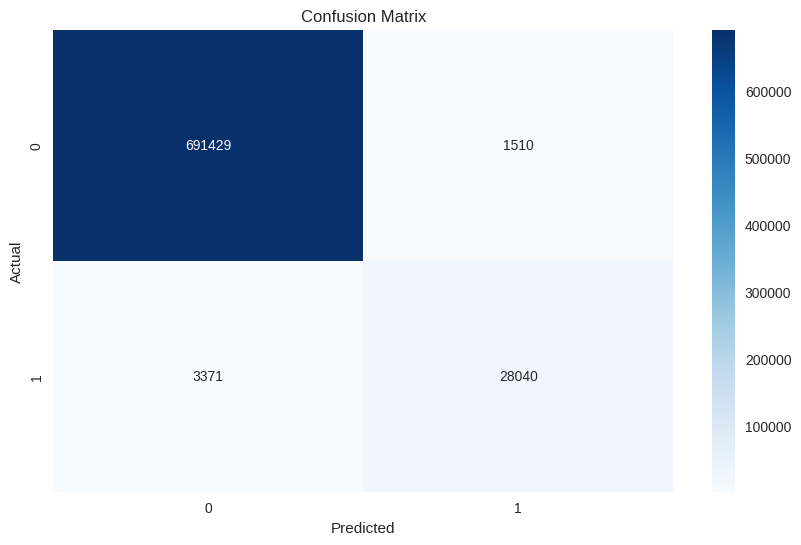

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=10, criterion='entropy', random_state=0)

#Train the model using the training sets
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test.fillna(0))

model_result(y_test,y_pred, version='ExtraTreesClassifier_entropy')

## Random Forest

roc_auc_score :  0.9493129773044248
accuracy_score:  0.994026368468282
precision_score:  0.9593934459596988
recall_score:  0.9003533793893859
f1-score : 0.9289362610652171
confusion_matrix:  [[691742   1197]
 [  3130  28281]]

confusion_matrix



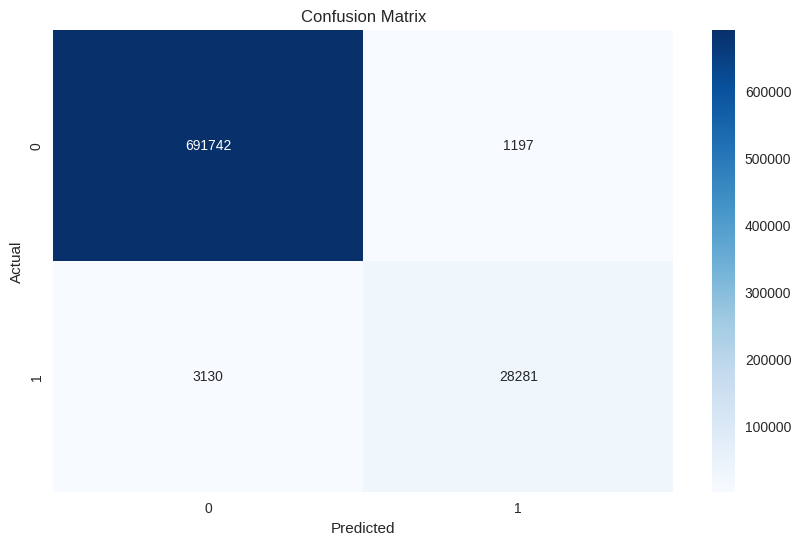

In [ ]:
from sklearn.ensemble import RandomForestClassifier


random_forest_clf = RandomForestClassifier(max_depth=20)

#Train the model using the training sets
random_forest_clf.fit(x_train, y_train)
y_pred = random_forest_clf.predict(x_test.fillna(0))

model_result(y_test,y_pred, version='RandomForestClassifier')

## Neural Network

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y_int, random_state=42, test_size=0.25, shuffle=True)

In [ ]:
# computing class weights for unbalenced data
from sklearn.utils import class_weight

weight = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_train), y = y_train)
weights = {i : weight[i] for i in range(2)}
weights

{0: 0.5226112549548323, 1: 11.556440719429052}

In [ ]:
from numpy import argmax
from keras.utils import to_categorical

# one hot encoding
y_train = to_categorical(y_train)
print('y_train onehot:')
print(y_train)


# one hot encoding
y_test = to_categorical(y_test)
print('y_test onehot:')
print(y_test)

y_train onehot:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
y_test onehot:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
  ])
model

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
model.fit(x_train, y_train, batch_size=256, epochs=20, class_weight=weights)

Epoch 1/15
8489/8489 [==============================] - 39s 5ms/step - loss: 0.1624 - accuracy: 0.9175
Epoch 2/15
8489/8489 [==============================] - 37s 4ms/step - loss: 0.1622 - accuracy: 0.9179
Epoch 3/15
8489/8489 [==============================] - 36s 4ms/step - loss: 0.1619 - accuracy: 0.9179
Epoch 4/15
8489/8489 [==============================] - 37s 4ms/step - loss: 0.1617 - accuracy: 0.9181
Epoch 5/15
8489/8489 [==============================] - 35s 4ms/step - loss: 0.1615 - accuracy: 0.9182
Epoch 6/15
8489/8489 [==============================] - 37s 4ms/step - loss: 0.1612 - accuracy: 0.9179
Epoch 7/15
8489/8489 [==============================] - 37s 4ms/step - loss: 0.1610 - accuracy: 0.9181
Epoch 8/15
8489/8489 [==============================] - 35s 4ms/step - loss: 0.1605 - accuracy: 0.9183
Epoch 9/15
8489/8489 [==============================] - 36s 4ms/step - loss: 0.1599 - accuracy: 0.9182
Epoch 10/15
8489/8489 [==============================] - 35s 4ms/step - l

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1582666039466858
Test accuracy: 0.9212231636047363


In [ ]:
y_pred = model.predict(x_test)
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(y_pred,axis=1)
print(f"Actual: {actual}")
print(f"Predicted: {predicted}")

22636/22636 [==============================] - 44s 2ms/step
Actual: [0 0 0 ... 0 0 0]
Predicted: [0 0 0 ... 0 0 0]


roc_auc_score :  0.9343902481225206
accuracy_score:  0.9212231655967419
precision_score:  0.34956660450168314
recall_score:  0.9488077425105854
f1-score : 0.5109027325401995
confusion_matrix:  [[637485  55454]
 [  1608  29803]]

confusion_matrix



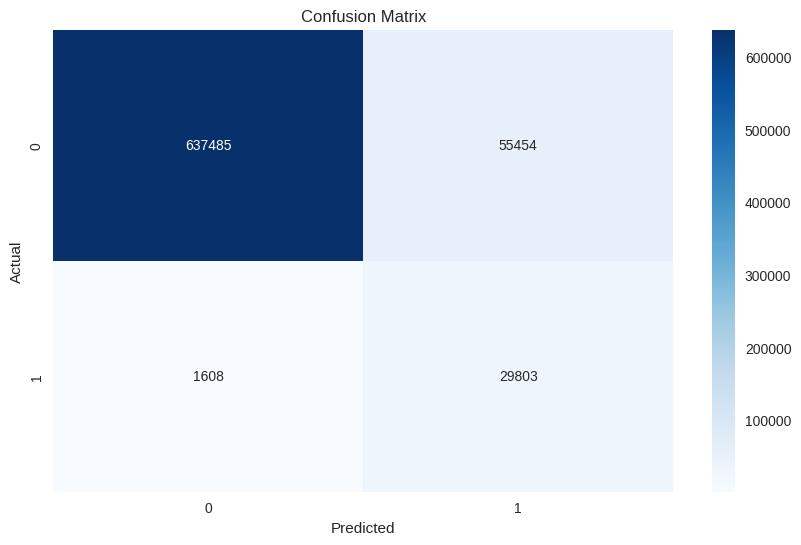

In [ ]:
model_result(actual, predicted, version='Neural Network')